# Datenanalyse der Brettspielwelt-DB

## 3. ScoreCum skalieren

Der kumulative Score ist ein nummerischer kontinuierlicher Wert.

* **Theoretischer Bereich:** [-INF, 995]
* **Schrittweite:** 5 (..., -15, -10, -5, 0, 5, 10, 15, ...)
* **Datenmenge:** 44.000.296 Werte (2 * 22.000.148 Runden a fehlerfreien Partien)

**Analyseergebnis**

1. Ich wandle den Score zur Zieldistanz um: `points_to_win = 1000 - score_cum`
2. **Transformation**: Ich führe eine logarithmische Transformation der Zieldistanz durch: `points_to_win_log = log(points_to_win)`
*  **Clipping**: Nicht notwendig wegen der logarithmischen Transformation.
*  **Skalierung**: Ich wähle die Standardisierung (Z-Score-Skalierung).
    * Mittelwert: 6,269208612739885
    * Standardabweichung: 0,8026322605703965


### 3.1 Daten abfragen

In [31]:
%%sql
select r.score_cum_20 as score_cum
from rounds as r
inner join games as g on r.game_id = g.id
where g.error_code = 0
union all
select score_cum_31 as score_cum
from rounds as r
inner join games as g on r.game_id = g.id
where g.error_code = 0


,score_cum
0,0
1,25
2,220
3,520
4,685
...,...
44000291,305
44000292,330
44000293,245
44000294,305


### 3.2 Statistischen Kennzahlen

In [32]:
# Berechne die wichtigsten statistischen Kennzahlen für den kumulativen Score

#import pandas as pd
#import numpy as np

stats_cum = df1['score_cum'].describe(percentiles=[0.005, .01, .05, .95, .99, .995])
count = stats_cum['count']
mean_cum = stats_cum['mean']
stdev_cum = stats_cum['std'] # .std() in Pandas verwendet standardmäßig ddof=1 (Stichprobe)
min_cum = stats_cum['min']
max_cum = stats_cum['max']
p005_cum = stats_cum['0.5%']
p995_cum = stats_cum['99.5%']
p01_cum = stats_cum['1%']
p99_cum = stats_cum['99%']
p05_cum = stats_cum['5%']
p95_cum = stats_cum['95%']

print(f"Anzahl der Werte der fehlerfreien Partien: {count:.0f}")

print("\n-- Kumulativer Score: --")
print(f"Mittelwert: {mean_cum:.2f} ± {stdev_cum:.2f}")
print(f"Bereich: [{min_cum:.0f}, {max_cum:.0f}]")
print(f"99% aller Werte liegen zwischen {p005_cum:.0f} und {p995_cum:.0f}.")
print(f"98% aller Werte liegen zwischen {p01_cum:.0f} und {p99_cum:.0f}.")
print(f"90% aller Werte liegen zwischen {p05_cum:.0f} und {p95_cum:.0f}.")
# Gibt es Ausreißer in total_score?
has_outliers = (min_cum < p005_cum - stdev_cum) or (max_cum > p995_cum + stdev_cum)
if has_outliers:
    print("Es gibt signifikante Ausreißer.")
else:
    print("Die Datenverteilung hat keine extremen Ausreißer.")

Anzahl der Werte der fehlerfreien Partien: 44000296

-- Kumulativer Score: --
Mittelwert: 350.47 ± 310.30
Bereich: [-1745, 995]
99% aller Werte liegen zwischen -285 und 985.
98% aller Werte liegen zwischen -200 und 975.
90% aller Werte liegen zwischen -30 und 900.
Es gibt signifikante Ausreißer.


### 3.3 Histogramm (Verteilungsdiagramm)

Ein Histogramm zeigt die Häufigkeit von Werten in einem Datensatz – also wie oft Werte in bestimmten Intervallen (Bins) vorkommen.

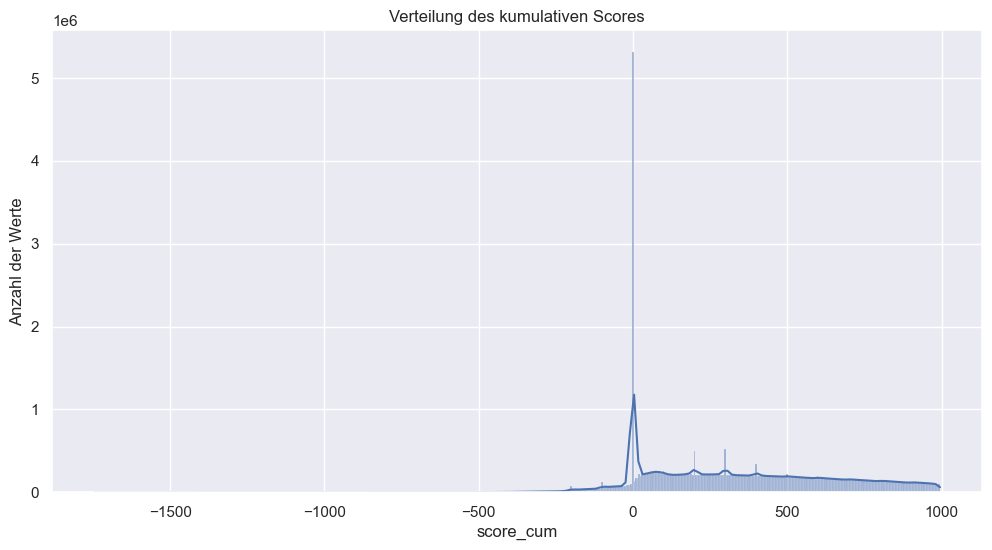

In [33]:
# Histogramm
# bins = max_cum/5 - min_cum/5 + 1 = 995/5 - -1745/5 + 1 = 549

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df1['score_cum'], bins=549, kde=True)
plt.title('Verteilung des kumulativen Scores')
plt.xlabel('score_cum')
plt.ylabel('Anzahl der Werte')
plt.grid(True)
plt.show()

**Interpretation**

* **Keine Symmetrie:** Im Gegensatz zu den Runden-Scores (die um 0 zentriert waren), sind die kumulativen Partie-Scores es nicht. Das ist logisch, da Teams Punkte sammeln und sich vom Nullpunkt wegbewegen.
* **"Rennen zum Ziel":** Die meisten Spielzustände treten auf, wenn Teams bereits einen signifikanten Punktestand haben und sich der 1000-Punkte-Grenze nähern. Zustände am Anfang einer Partie (Score nahe 0) sind seltener als Zustände in der Mitte oder am Ende.
* **Langer Verlust-Schwanz:** Es ist seltener, einen stark negativen Gesamtpunktestand zu haben, aber es kommt vor (daher der lange Schwanz nach links).
* **Die kleinen "Beulen":** Die wellenartige Struktur im positiven Bereich spiegelt wieder die diskreten Punktesprünge wider (Runden enden oft mit Scores um 100, 200 etc.).

### 3.4 Logarithmische Transformation

Die 1000-Punkte-Grenze ist für `score_cum` der Bezug. Je näher die Punkte an dieser Grenze sind, desto wichtiger sind sie.

**WICHITG:** Dieser Zusammenhang (Wichtigkeit zu Abstand) ist NICHT linear! Daher bietet sich eine linera Transformation für die Skalierung noch nicht an. Standardisierung (Z-Score-Skalierung) und Normalisierung (Min-Max-Skalierung) sind also für die Daten in dieser Form ungeeignet.

Ich wähle daher eine **logarithmische Transformation**.

Sie macht die Verteilung "normaler": Eine stark schiefe Verteilung wird durch die Log-Transformation oft in eine Form gebracht, die eine Glockenkurve viel ähnlicher sieht. Das ist für viele statistische Modelle und neuronale Netze ein idealer Zustand.

<img src="ln-graph.png">

Beim Logarithmus muss das Argument größer 0 sein. Je näher der Wert an die 0 rückt, desto sensibler reagiert die Funktion auf eine Änderung.
Wir müssen den Score also gespiegelt transformieren, so dass die 1000-Punkte-Grenze (die nie erreicht und nie überschritten wird) gleich 0 ist. Je weiter diese Grenze entfernt ist, desto größer ist der transformierte Wert und desto schwächer die Funktion.

Das Argument der logarithmischen Funktion ist also nicht direkt der kumulative Score, sondern der Abstand zum Ziel, die "Zieldistanz" `points_to_win`.

* `points_to_win = 1000 - score_cum`
* Theoretischer Bereich: [5, INF]  (resultiert aus dem Bereich von `score_cum`: [-INF, 995])
* Schrittweite: 5 (wie bei `score_cum`)

Die finale Formel lautet:

`points_to_win_scale = log(max(5, 1000 - score_cum))`

oder falls sichergestellt ist, dass `score_cum` nicht größer als 995 ist:

`points_to_win_scale = log(1000 - score_cum)`

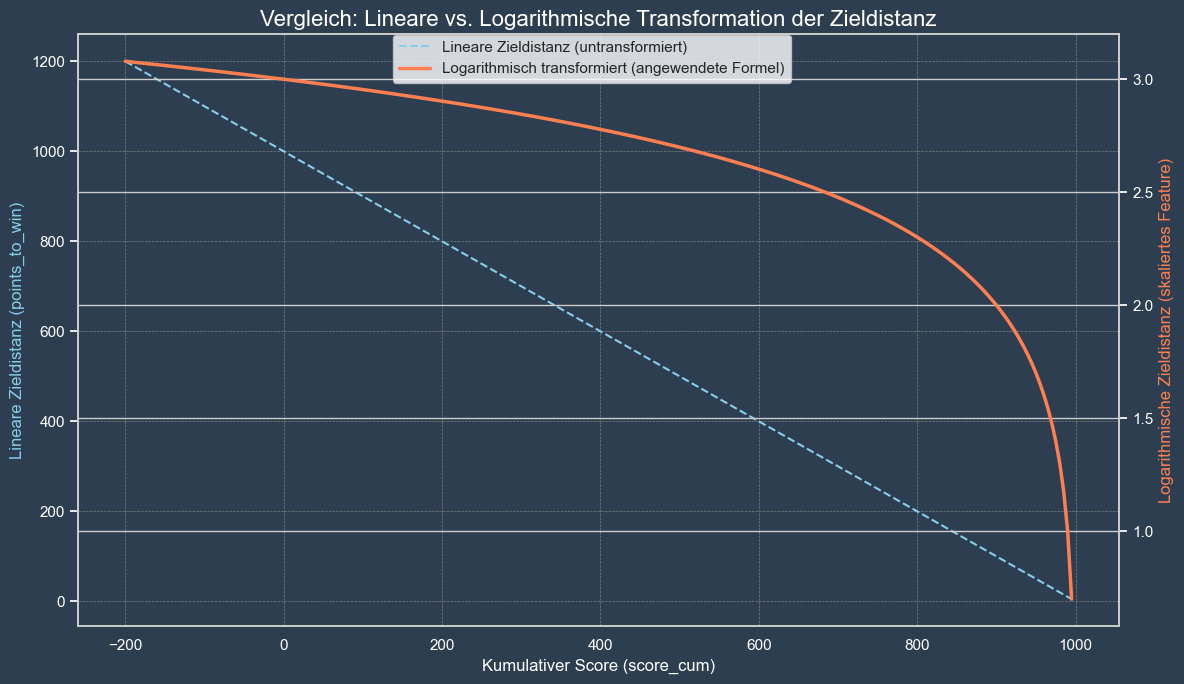

In [34]:
# Darstellung, die den Effekt der Transformation verdeutlicht

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setze einen schönen Stil
sns.set_theme(style="whitegrid", rc={"axes.edgecolor": ".8", "figure.facecolor": "#2c3e50"})

# Erstelle einen Bereich von kumulativen Scores, die uns interessieren
score_cum = np.arange(-200, 1000, 5)

# Berechne die lineare Zieldistanz
points_to_win_linear = 1000 - score_cum

# Berechne deine transformierte Zieldistanz.
# Wir verwenden np.log10 für eine leichter interpretierbare Skala auf der y-Achse.
points_to_win_log = np.log10(np.maximum(5, 1000 - score_cum))

# --- Erstelle den Plot ---
fig, ax1 = plt.subplots(figsize=(12, 7))

# Farbe für die lineare Achse
color_linear = 'skyblue'
ax1.set_xlabel('Kumulativer Score (score_cum)', fontsize=12, color='white')
ax1.set_ylabel('Lineare Zieldistanz (points_to_win)', color=color_linear, fontsize=12)
ax1.plot(score_cum, points_to_win_linear, color=color_linear, linestyle='--', label='Lineare Zieldistanz (untransformiert)')
ax1.tick_params(axis='y', labelcolor=color_linear)
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

# Erstelle eine zweite y-Achse für die transformierten Werte
ax2 = ax1.twinx()
color_log = 'coral'
ax2.set_ylabel('Logarithmische Zieldistanz (skaliertes Feature)', color=color_log, fontsize=12)
ax2.plot(score_cum, points_to_win_log, color=color_log, linewidth=2.5, label='Logarithmisch transformiert (angewendete Formel)')
ax2.tick_params(axis='y', labelcolor=color_log)
ax2.tick_params(axis='y', colors='white')

# Titel und Legende
plt.title('Vergleich: Lineare vs. Logarithmische Transformation der Zieldistanz', fontsize=16, color='white')
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
ax1.grid(color='gray', linestyle='--', linewidth=0.5)

# Hintergrundfarben für den Plot
ax1.set_facecolor('#2c3e50')
fig.set_facecolor('#2c3e50')

plt.show()

**Interpretation**

* Die gestrichelte, blaue Linie (Lineare Zieldistanz):
  * Sie zeigt, dass der Unterschied zwischen 900 und 950 Punkten (ein Abstand von 50) auf der y-Achse genauso groß ist wie der Unterschied zwischen 100 und 150 Punkten.
* Die durchgezogene, orange Linie (Logarithmische Zieldistanz):
  * Im Bereich hoher Scores (z.B. > 800): Die Kurve ist sehr steil. Eine kleine Änderung des score_cum (z.B. von 950 auf 970) führt zu einer großen Änderung des transformierten Wertes auf der y-Achse. Das signalisiert dem Netz: "Achtung, hier passiert etwas Wichtiges!"
  * Im Bereich niedriger Scores (z.B. < 400): Die Kurve ist sehr flach. Eine große Änderung des score_cum (z.B. von 100 auf 300) führt nur zu einer kleinen Änderung des transformierten Wertes. Das signalisiert dem Netz: "Ob du nun 700 oder 900 Punkte brauchst, ist strategisch für den nächsten Zug fast dasselbe."

In [35]:
# Logarithmische Transformation der Zieldistanz
# SQL-Syntax: log(score_cum - min_cum)
import numpy as np
df1['points_to_win_log'] = np.log(1000 - df1['score_cum'])
df1['points_to_win_log']

0           6.907755
1           6.882437
2           6.659294
3           6.173786
4           5.752573
              ...   
44000291    6.543912
44000292    6.507278
44000293    6.626718
44000294    6.543912
44000295    6.543912
Name: points_to_win_log, Length: 44000296, dtype: float64

In [36]:
# Kennzahlen der Zieldistanz nach der logarithmischen Transformation

#import pandas as pd
#import numpy as np

stats_cum = df1['points_to_win_log'].describe(percentiles=[0.005, .01, .05, .95, .99, .995])
count = stats_cum['count']
mean_cum = stats_cum['mean']
stdev_cum = stats_cum['std'] # .std() in Pandas verwendet standardmäßig ddof=1 (Stichprobe)
min_cum = stats_cum['min']
max_cum = stats_cum['max']
p005_cum = stats_cum['0.5%']
p995_cum = stats_cum['99.5%']
p01_cum = stats_cum['1%']
p99_cum = stats_cum['99%']
p05_cum = stats_cum['5%']
p95_cum = stats_cum['95%']

print(f"Anzahl der Werte der fehlerfreien Partien: {count:.0f}")

print("\n-- Kumulativer Score: --")
print(f"Mittelwert: {mean_cum:.2f} ± {stdev_cum:.2f}")
print(f"Bereich: [{min_cum:.2f}, {max_cum:.2f}]")
print(f"99% aller Werte liegen zwischen {p005_cum:.2f} und {p995_cum:.2f}.")
print(f"98% aller Werte liegen zwischen {p01_cum:.2f} und {p99_cum:.2f}.")
print(f"90% aller Werte liegen zwischen {p05_cum:.2f} und {p95_cum:.2f}.")
# Gibt es Ausreißer in total_score?
has_outliers = (min_cum < p005_cum - stdev_cum) or (max_cum > p995_cum + stdev_cum)
if has_outliers:
    print("Es gibt signifikante Ausreißer.")
else:
    print("Die Datenverteilung hat keine extremen Ausreißer.")

Anzahl der Werte der fehlerfreien Partien: 44000296

-- Kumulativer Score: --
Mittelwert: 6.27 ± 0.80
Bereich: [1.61, 7.92]
99% aller Werte liegen zwischen 2.71 und 7.16.
98% aller Werte liegen zwischen 3.22 und 7.09.
90% aller Werte liegen zwischen 4.61 und 6.94.
Es gibt signifikante Ausreißer.


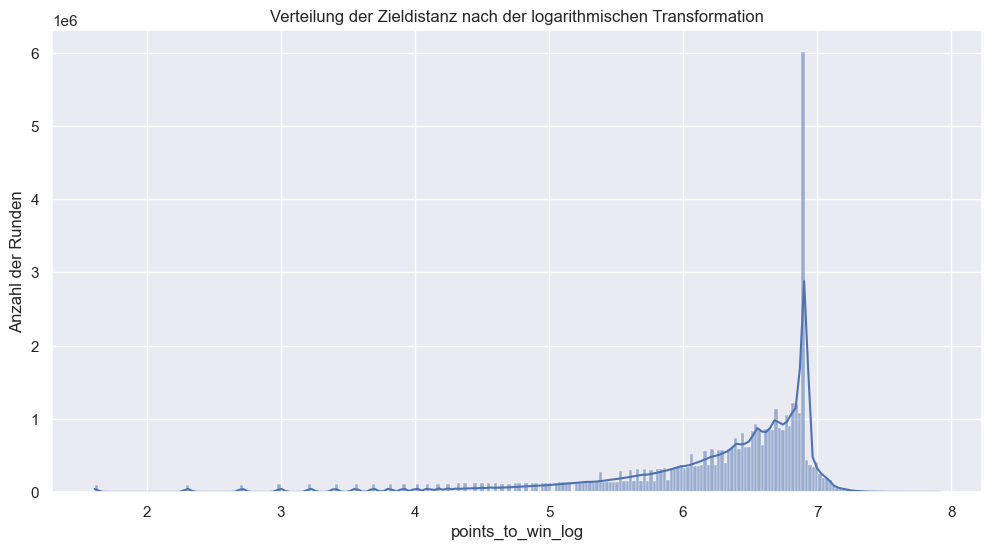

In [41]:
# Histogramm
plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='points_to_win_log', bins=250, kde=True)
plt.title('Verteilung der Zieldistanz nach der logarithmischen Transformation')
plt.xlabel('points_to_win_log')
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

### 3.5 Clipping

Nicht notwendig nach einer logarithmischen Transformation.

### 3.6 Skalieren

Ich wähle die Standardisierung (Z-Score-Skalierung), da der Wert ein Input-Feature ist.

In [42]:
# Skalierung – Z-Score (Standardisierung)
# SQL-Syntax: (score - avg) / stddev

stats = df1['points_to_win_log'].describe()
df1['points_to_win_log_scale'] = (df1['points_to_win_log'] - stats['mean']) / stats['std']

# Kennzahlen der standardisierten Werte
stats = df1['points_to_win_log_scale'].describe()
print(f"Mittelwert (sollte ~0 sein): {stats['mean']:.6f}")
print(f"Standardabweichung (sollte ~1 sein): {stats['std']:.6f}")
print(f"Bereich: [{stats['min']:.2f}, {stats['max']:.2f}]")

Mittelwert (sollte ~0 sein): -0.000000
Standardabweichung (sollte ~1 sein): 1.000000
Bereich: [-5.81, 2.05]


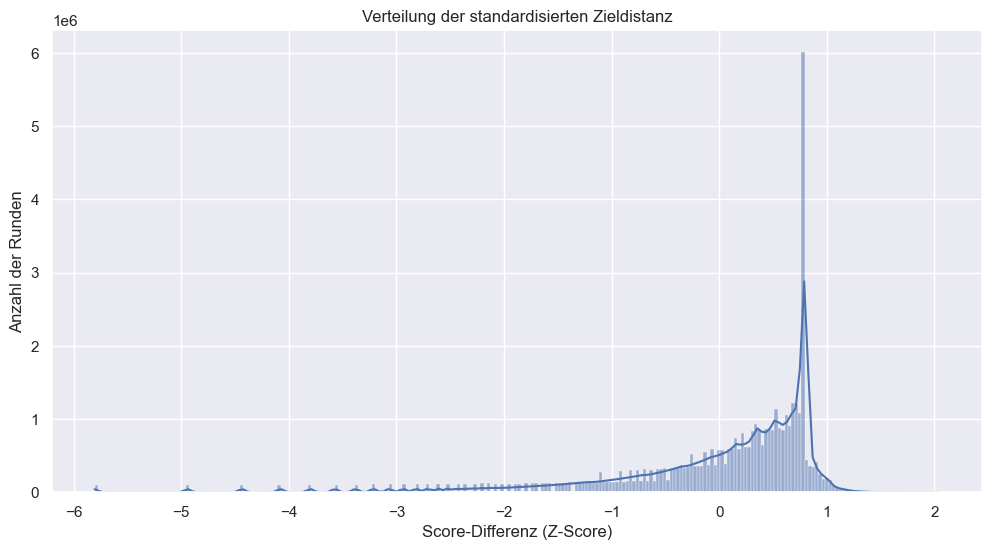

In [43]:
# Histogramm
plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='points_to_win_log_scale', bins=250, kde=True)
plt.title('Verteilung der standardisierten Zieldistanz')
plt.xlabel('Score-Differenz (Z-Score)')
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

* Ein skalierter Log-Wert von -5.81 bedeutet, dass das Team extrem nah an der 1000-Punkte-Grenze dran ist und die Partie fast gewonnen hat.
* Ein skalierter Log-Wert von 2.05 bedeutet, dass das Team extrem weit vom Sieg entfernt ist.

In [53]:
stats_log = df1['points_to_win_log'].describe()
mean_log = stats_log['mean']
stdev_log = stats_log['std']
mean_log, stdev_log

(np.float64(6.269208612739885), np.float64(0.8026322605703965))

In [55]:
(np.log(1000 - 995) - mean_log) / stdev_log

np.float64(-5.80561102414982)

In [56]:
(np.log(1000 - -1745) - mean_log) / stdev_log

np.float64(2.053652490908289)